In [40]:
import pandas as pd
import numpy as np
import scipy.io

import matplotlib.pyplot as plt

import datetime as dt

In [1]:
# Import libraries
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
availale_GPUs = len(physical_devices)
print('Using TensorFlow version: ', tf.__version__, ', GPU:', availale_GPUs)
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
import numpy as np
import scipy.io
from tensorflow.keras.layers import Input, Activation, Dense
from tensorflow.keras.models import Model
import pandas as pd
import datetime as dt
import tensorflow_addons as tfa

Using TensorFlow version:  2.12.0 , GPU: 0


c:\Users\User\Documents\Proyectos Python\TG\venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [66]:
# Extract data from dataset

WS_data = scipy.io.loadmat('..\\data\\Weather_data.mat')

In [4]:
WS_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Date', 'Lon', 'Lat', 'Alt', 'Temperature', 'WindSpeed', 'WindDirectionX', 'WindDirectionY', 'Pressure'])

In [5]:
WS_cols = list(WS_data.keys())[3:]

In [6]:
for col in WS_cols:
  print(col)
  print(WS_data[col].shape)

Date
(1, 42336)
Lon
(1, 42336)
Lat
(1, 42336)
Alt
(1, 42336)
Temperature
(1, 42336)
WindSpeed
(1, 42336)
WindDirectionX
(1, 42336)
WindDirectionY
(1, 42336)
Pressure
(1, 42336)


In [7]:
# Convert date to continuous time: from date and time format to seconds
date_0 = WS_data['Date'][0]
date = []
for i in range(0, len(date_0)):
    date = np.append(date, str(date_0[i])[2 : -2])
time_init = dt.datetime(int(date[0][0 : 4]), int(date[0][5 : 7]), int(date[0][8 : 10]), int(date[0][11 : 13]), int(date[0][14 : 16]))
T_nan_index = np.argwhere(pd.isna(date))
date = np.delete(date, T_nan_index[:, 0],  0)
print('Double-check for NaN in time sequence', np.sum(pd.isna(date)))

Double-check for NaN in time sequence 0


In [8]:
Seconds = np.zeros((date.shape[0], 1))
for index in range(date.shape[0]):
    Seconds[index, 0] = ((dt.datetime(int(date[index][0 : 4]), int(date[index][5 : 7]), int(date[index][8 : 10]), int(date[index][11 : 13]), int(date[index][14 : 16])) - time_init).total_seconds())
T_WS = Seconds

In [9]:
# Convert to Cartesian coordinates
X_WS = np.array(6378000 * np.sin(np.radians(WS_data['Lon'])))[0]  # Longitude to meters
Y_WS = np.array(6378000 * np.sin(np.radians(WS_data['Lat'])))[0]  # Latitude to meters
Z_WS = np.array(WS_data['Alt'])[0]
Temp_WS = np.array(WS_data['Temperature'])[0]

In [10]:
# Project wind speed and direction into Cartesian coordinates
U_WS = (WS_data['WindSpeed'] * WS_data['WindDirectionX'])[0]
V_WS = (WS_data['WindSpeed'] * WS_data['WindDirectionY'])[0]

In [11]:
# Pressure from mbar to Pa
P_WS = WS_data['Pressure'][0] * 100

In [12]:
# Remove NaN values from time field
X_WS = np.delete(X_WS, T_nan_index[:, 0],  0)
Y_WS = np.delete(Y_WS, T_nan_index[:, 0],  0)
Z_WS = np.delete(Z_WS, T_nan_index[:, 0],  0)
U_WS = np.delete(U_WS, T_nan_index[:, 0],  0)
V_WS = np.delete(V_WS, T_nan_index[:, 0],  0)
P_WS = np.delete(P_WS, T_nan_index[:, 0],  0)
Temp_WS = np.delete(Temp_WS, T_nan_index[:, 0],  0)

In [13]:
# Structure data into matrix: 21 available stations (rows) x measurement every 10 min (column)
T_WS = np.reshape(T_WS, (int(T_WS.shape[0] / 21), 21)).T # There are 21 WS stations in this case
X_WS = np.reshape(X_WS, (T_WS.shape[1], T_WS.shape[0])).T
Y_WS = np.reshape(Y_WS, (T_WS.shape[1], T_WS.shape[0])).T
Z_WS = np.reshape(Z_WS, (T_WS.shape[1], T_WS.shape[0])).T
U_WS = np.reshape(U_WS, (T_WS.shape[1], T_WS.shape[0])).T
V_WS = np.reshape(V_WS, (T_WS.shape[1], T_WS.shape[0])).T
P_WS = np.reshape(P_WS, (T_WS.shape[1], T_WS.shape[0])).T
Temp_WS = np.reshape(Temp_WS, (T_WS.shape[1], T_WS.shape[0])).T
print('Number of weather stations:', T_WS.shape[0])

Number of weather stations: 21


In [14]:
# Remove NaN from location data
X_nan_index = np.argwhere(np.isnan(X_WS))
T_WS = np.delete(T_WS, X_nan_index[:, 0],  0)
P_WS = np.delete(P_WS, X_nan_index[:, 0],  0)
U_WS = np.delete(U_WS, X_nan_index[:, 0],  0)
V_WS = np.delete(V_WS, X_nan_index[:, 0],  0)
X_WS = np.delete(X_WS, X_nan_index[:, 0],  0)
Y_WS = np.delete(Y_WS, X_nan_index[:, 0],  0)
Z_WS = np.delete(Z_WS, X_nan_index[:, 0],  0)
Temp_WS = np.delete(Temp_WS, X_nan_index[:, 0],  0)
print('Double-check for NaN in location field', np.sum(np.isnan(X_WS)))

Double-check for NaN in location field 0


In [15]:
# Days selected for reconstruction
n_days = 14 # Change up to a maximum of 14 availsble days
samples =  int(144 * n_days) # Convert selected days to snapshots
T_WS = T_WS[:, : samples]
X_WS = X_WS[:, : samples]
Y_WS = Y_WS[:, : samples]
Z_WS = Z_WS[:, : samples]
U_WS = U_WS[:, : samples]
V_WS = V_WS[:, : samples]
P_WS = P_WS[:, : samples]
Temp_WS = Temp_WS[:, : samples]

In [16]:
# Sort values in matrix into increasing values of X coordinate
for snap in range(0, T_WS.shape[1]):
    index_sort = np.argsort(X_WS[:, snap])
    T_WS[:, snap] = T_WS[index_sort, snap]
    X_WS[:, snap] = X_WS[index_sort, snap]
    Y_WS[:, snap] = Y_WS[index_sort, snap]
    Z_WS[:, snap] = Z_WS[index_sort, snap]
    U_WS[:, snap] = U_WS[index_sort, snap]
    V_WS[:, snap] = V_WS[index_sort, snap]
    P_WS[:, snap] = P_WS[index_sort, snap]
    Temp_WS[:, snap] = Temp_WS[index_sort, snap]

In [17]:
# Delete NaN from U, V and P if constantly occuring for each weather station
uvp_mean = np.nanmean(np.concatenate([U_WS, V_WS, P_WS], axis = 1), axis = 1)[:, None]
vel_nan_index = np.argwhere(np.isnan(uvp_mean))
T_WS = np.delete(T_WS, vel_nan_index[:, 0],  0)
P_WS = np.delete(P_WS, vel_nan_index[:, 0],  0)
U_WS = np.delete(U_WS, vel_nan_index[:, 0],  0)
V_WS = np.delete(V_WS, vel_nan_index[:, 0],  0)
X_WS = np.delete(X_WS, vel_nan_index[:, 0],  0)
Y_WS = np.delete(Y_WS, vel_nan_index[:, 0],  0)
Z_WS = np.delete(Z_WS, vel_nan_index[:, 0],  0)
Temp_WS = np.delete(Temp_WS, vel_nan_index[:, 0],  0)

In [18]:
# Correct pressure to sea level (ISA)
P_WS = P_WS * (1 - 0.0065 * Z_WS / (Temp_WS + 273.15 + 0.0065 * Z_WS))**(-5.257)

In [19]:
# Certering of location and time fields
x_min = np.min(X_WS)
x_max = np.max(X_WS)
X_WS = X_WS - (x_min + x_max) / 2
y_min = np.min(Y_WS)
y_max = np.max(Y_WS)
Y_WS = Y_WS - (y_min + y_max) / 2
t_min = np.min(T_WS)
t_max = np.max(T_WS)
T_WS = T_WS - t_min # Refer to t = 0

In [20]:
# PINN output grid
T_PINN = T_WS[0 : 1, :] # Same times for reconstruction

In [21]:
# Resolution in degrees
R = 0.2
R_PINN = 6_378_000 * np.sin(np.radians(R)) # Grid resolution
x_PINN = np.arange(x_min - R_PINN, x_max + R_PINN, R_PINN) # X values in output resolution
y_PINN = np.arange(y_min - R_PINN, y_max + R_PINN, R_PINN) # Y values in output resolution

In [22]:
# Centering of location data
x_PINN = x_PINN - (x_min + x_max) / 2
y_PINN = y_PINN - (y_min + y_max) / 2

In [23]:
# Final output grid
X_PINN, Y_PINN = np.meshgrid(x_PINN, y_PINN)
X_PINN = X_PINN.flatten('F')[:, None]
Y_PINN = Y_PINN.flatten('F')[:, None]

In [24]:
# Dimensions
dim_T_PINN = T_PINN.shape[1]
dim_N_PINN = X_PINN.shape[0]


T_PINN = np.tile(T_PINN, (dim_N_PINN, 1))
X_PINN = np.tile(X_PINN, dim_T_PINN)
Y_PINN = np.tile(Y_PINN, dim_T_PINN)

In [25]:
# Reference values for non-dimensionalization
L = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2) # Reference distance
W = np.sqrt(np.nanmax(abs(U_WS)) ** 2 + np.nanmax(abs(V_WS)) ** 2) # Reference velocity
rho = 1.269 # Air density at 15 degrees
nu = 1.382e-5 # Kinematic viscosity at 15 degrees
Re = int(W * L / nu) # Reynolds number
P0 = np.nanmean(P_WS) # Reference pressure level
print('L:', L, 'W', W, 'P0', P0, 'Re', Re)

L: 409791.6159110926 W 16.718180196652117 P0 100359.48707895375 Re 495728659759


In [26]:
# Non-dimensionalization
X_WS = X_WS / L
Y_WS = Y_WS / L
T_WS = T_WS * W / L
P_WS = (P_WS - P0) / rho / (W ** 2)
U_WS = U_WS / W
V_WS = V_WS / W

X_PINN = X_PINN / L
Y_PINN = Y_PINN / L
T_PINN = T_PINN * W / L

In [27]:
# Validation cases (remove stations)
# # N_test = 0 # Number of stations to remove
WS_val = np.array([1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 16, 19])
# Choose between different arrays for desired validation case:
# Close: np.array([2, 8, 10, 14, 16, 19])
# Far: np.array([0, 1, 4, 6, 8, 12, 17, 18, 19, 20])
# Envelope: np.array([1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 16, 19])

In [28]:
# Remove WS for validation
T_val = T_WS[WS_val, :]
P_val = P_WS[WS_val, :]
U_val = U_WS[WS_val, :]
V_val = V_WS[WS_val, :]
X_val = X_WS[WS_val, :]
Y_val = Y_WS[WS_val, :]
Z_val = Z_WS[WS_val, :]

In [29]:
# Remaining Ws for training
T_WS = np.delete(T_WS, WS_val, 0)
P_WS = np.delete(P_WS, WS_val, 0)
U_WS = np.delete(U_WS, WS_val, 0)
V_WS = np.delete(V_WS, WS_val, 0)
X_WS = np.delete(X_WS, WS_val, 0)
Y_WS = np.delete(Y_WS, WS_val, 0)
print('Number of final weather stations available for training:', T_WS.shape[0])

Number of final weather stations available for training: 8


In [30]:
# Dimensions
dim_N_WS = X_WS.shape[0]
dim_T_WS = X_WS.shape[1]

del WS_data

In [31]:
# Customized dense layer
class GammaBiasLayer(tf.keras.layers.Layer):
    def __init__(self, units, *args, **kwargs):
        super(GammaBiasLayer, self).__init__(*args, **kwargs)
        self.units = units

    def build(self, input_shape):
        self.bias = self.add_weight('bias',
                                    shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)

        self.gamma = self.add_weight('gamma',
                                     shape = (self.units,),
                                     initializer = 'ones',
                                     trainable = True)

        self.w = tfa.layers.WeightNormalization(Dense(self.units, use_bias = False,
                                    kernel_initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None),
                                    trainable = True, activation = None))


    def call(self, input_tensor):
        return self.gamma * self.w(input_tensor) + self.bias

In [32]:
# Model
num_input_variables = 3 # t, x, y
num_output_variables = 3 # u, v, p

neurons = 200 * num_output_variables
layers = [num_input_variables] + (2 * (num_input_variables + num_output_variables))*[neurons] + [num_output_variables]

inputs = Input(shape = (num_input_variables, ))
h = GammaBiasLayer(layers[1])(inputs)
h = Activation('tanh')(h)
for l in layers[2 : 2 * int((len(layers) - 2) / 3)]:
    h = GammaBiasLayer(l)(h)
    h = Activation('tanh')(h)
for l in layers[2 * int((len(layers) - 2) / 3) : -1]:
    h = GammaBiasLayer(layers[-2])(h)
outputs = GammaBiasLayer(layers[-1])(h)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 gamma_bias_layer (GammaBias  (None, 600)              5401      
 Layer)                                                          
                                                                 
 activation (Activation)     (None, 600)               0         
                                                                 
 gamma_bias_layer_1 (GammaBi  (None, 600)              721801    
 asLayer)                                                        
                                                                 
 activation_1 (Activation)   (None, 600)               0         
                                                                 
 gamma_bias_layer_2 (GammaBi  (None, 600)              721801

In [33]:
# Error functions and loss function
mse = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()

@tf.function(reduce_retracing = True)
def loss_NS_2D(model, t_eqns_batch, x_eqns_batch, y_eqns_batch, training):
    mse = tf.keras.losses.MeanSquaredError()
    with tf.GradientTape(persistent = True) as tape1:
        tape1.watch((t_eqns_batch, x_eqns_batch, y_eqns_batch))
        X_eqns_batch = tf.concat([t_eqns_batch, x_eqns_batch, y_eqns_batch], axis = 1)
        Y_eqns_batch = model(X_eqns_batch, training = training)
        [u_eqns_pred, v_eqns_pred, p_eqns_pred] = tf.split(Y_eqns_batch, num_or_size_splits=Y_eqns_batch.shape[1], axis=1)

    # Derivatives
    u_t_eqns_pred = tape1.gradient(u_eqns_pred, t_eqns_batch)
    v_t_eqns_pred = tape1.gradient(v_eqns_pred, t_eqns_batch)

    u_x_eqns_pred = tape1.gradient(u_eqns_pred, x_eqns_batch)
    v_x_eqns_pred = tape1.gradient(v_eqns_pred, x_eqns_batch)
    p_x_eqns_pred = tape1.gradient(p_eqns_pred, x_eqns_batch)

    u_y_eqns_pred = tape1.gradient(u_eqns_pred, y_eqns_batch)
    v_y_eqns_pred = tape1.gradient(v_eqns_pred, y_eqns_batch)
    p_y_eqns_pred = tape1.gradient(p_eqns_pred, y_eqns_batch)

    # Navier-Stokes residuals
    e1 = (u_x_eqns_pred + v_y_eqns_pred)
    e2 = (u_t_eqns_pred + (u_eqns_pred * u_x_eqns_pred + v_eqns_pred * u_y_eqns_pred) + p_x_eqns_pred)
    e3 = (v_t_eqns_pred + (u_eqns_pred * v_x_eqns_pred + v_eqns_pred * v_y_eqns_pred) + p_y_eqns_pred)

    return mse(0, e1) + mse(0, e2) + mse(0, e3)

def loss_u(model, t_data_batch, x_data_batch, y_data_batch, u_data_batch, training):
    mse = tf.keras.losses.MeanSquaredError()
    X_data_batch = tf.concat([t_data_batch, x_data_batch, y_data_batch], axis = 1)
    Y_data_batch = model(X_data_batch, training = training)
    [u_data_pred, _, _] = tf.split(Y_data_batch, num_or_size_splits=Y_data_batch.shape[1], axis=1)

    return mse(u_data_batch, u_data_pred) / tf.math.reduce_std(u_data_batch)**2

def loss_v(model, t_data_batch, x_data_batch, y_data_batch, v_data_batch, training):
    mse = tf.keras.losses.MeanSquaredError()
    X_data_batch = tf.concat([t_data_batch, x_data_batch, y_data_batch], axis = 1)
    Y_data_batch = model(X_data_batch, training = training)
    [_, v_data_pred, _] = tf.split(Y_data_batch, num_or_size_splits=Y_data_batch.shape[1], axis=1)

    return mse(v_data_batch, v_data_pred) / tf.math.reduce_std(v_data_batch)**2

def loss_p(model, t_data_batch, x_data_batch, y_data_batch, p_data_batch, training):
    mse = tf.keras.losses.MeanSquaredError()
    X_data_batch = tf.concat([t_data_batch, x_data_batch, y_data_batch], axis = 1)
    Y_data_batch = model(X_data_batch, training = training)
    [_, _, p_data_pred] = tf.split(Y_data_batch, num_or_size_splits=Y_data_batch.shape[1], axis=1)

    return mse(p_data_batch, p_data_pred) / tf.math.reduce_std(p_data_batch)**2

def loss_total(model, t_u_batch, x_u_batch, y_u_batch, u_u_batch, t_v_batch, x_v_batch, y_v_batch, v_v_batch, t_p_batch, x_p_batch, y_p_batch, p_p_batch, t_eqns_ref_batch, x_eqns_ref_batch, y_eqns_ref_batch, t_eqns_batch, x_eqns_batch, y_eqns_batch, lamb, training):
    NS_eqns = lamb * loss_NS_2D(model, t_eqns_batch, x_eqns_batch, y_eqns_batch, training)
    NS_data = lamb * loss_NS_2D(model, t_eqns_ref_batch, x_eqns_ref_batch, y_eqns_ref_batch, training)
    P_e = loss_p(model, t_p_batch, x_p_batch, y_p_batch, p_p_batch, training)
    U_e = loss_u(model, t_u_batch, x_u_batch, y_u_batch, u_u_batch, training)
    V_e = loss_v(model, t_v_batch, x_v_batch, y_v_batch, v_v_batch, training)

    total_e = NS_eqns + NS_data + U_e + V_e + P_e

    return  (NS_eqns ** 2 + NS_data**2 + U_e ** 2 + V_e ** 2 + P_e ** 2) / total_e

In [34]:
# Optimize model - gradients:
def grad(model, t_u_batch, x_u_batch, y_u_batch, u_u_batch, t_v_batch, x_v_batch, y_v_batch, v_v_batch,  t_p_batch, x_p_batch, y_p_batch, p_p_batch, t_eqns_ref_batch, x_eqns_ref_batch, y_eqns_ref_batch, t_eqns_batch, x_eqns_batch, y_eqns_batch, lamb):
    with tf.GradientTape() as tape:
        loss_value = loss_total(model, t_u_batch, x_u_batch, y_u_batch, u_u_batch, t_v_batch, x_v_batch, y_v_batch, v_v_batch,  t_p_batch, x_p_batch, y_p_batch, p_p_batch, t_eqns_ref_batch, x_eqns_ref_batch, y_eqns_ref_batch, t_eqns_batch, x_eqns_batch, y_eqns_batch, lamb, training = True)
    gradient_model = tape.gradient(loss_value, model.trainable_variables)
    return loss_value, gradient_model

In [35]:
# Create an optimizer
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

In [36]:
# Keep results for plotting
train_loss_results = []
NS_loss_results = []
P_loss_results = []
U_loss_results = []
V_loss_results = []

In [37]:
# Training
num_epochs = 1000 # number of epochs
lamb = 2 # Tuning of physics constraints
batch_PINN = int(np.ceil((dim_N_PINN * dim_T_PINN / n_days * R)))
batch_WS = int(np.ceil(dim_N_WS * dim_T_WS / n_days * R))

In [38]:
# Data dimensions
dim_N_data = dim_N_WS
dim_T_data = dim_T_WS
dim_T_eqns = dim_T_PINN
dim_N_eqns = dim_N_PINN

-------------------------------

In [41]:
  # Data mixing and shuffling
  idx_t = np.random.choice(dim_T_WS, dim_T_data, replace = False)
  idx_x = np.random.choice(dim_N_WS, dim_N_data, replace = False)
  t_u = T_WS[:, idx_t][idx_x,:].flatten()[:,None]
  x_u = X_WS[:, idx_t][idx_x,:].flatten()[:,None]
  y_u = Y_WS[:, idx_t][idx_x,:].flatten()[:,None]
  z_u = Z_WS[:, idx_t][idx_x,:].flatten()[:,None]
  u_u = U_WS[:, idx_t][idx_x,:].flatten()[:,None]
  v_u = V_WS[:, idx_t][idx_x,:].flatten()[:,None]
  p_u = U_WS[:, idx_t][idx_x,:].flatten()[:,None]

  idx_t = np.random.choice(dim_T_WS, dim_T_data, replace = False)
  idx_x = np.random.choice(dim_N_WS, dim_N_data, replace = False)
  t_v = T_WS[:, idx_t][idx_x,:].flatten()[:,None]
  x_v = X_WS[:, idx_t][idx_x,:].flatten()[:,None]
  y_v = Y_WS[:, idx_t][idx_x,:].flatten()[:,None]
  z_v = Z_WS[:, idx_t][idx_x,:].flatten()[:,None]
  u_v = U_WS[:, idx_t][idx_x,:].flatten()[:,None]
  v_v = V_WS[:, idx_t][idx_x,:].flatten()[:,None]
  p_v = U_WS[:, idx_t][idx_x,:].flatten()[:,None]

  idx_t = np.random.choice(P_WS.shape[1], P_WS.shape[1], replace = False)
  idx_x = np.random.choice(P_WS.shape[0], P_WS.shape[0], replace = False)
  t_p = T_WS[:, idx_t][idx_x,:].flatten()[:,None]
  x_p = X_WS[:, idx_t][idx_x,:].flatten()[:,None]
  y_p = Y_WS[:, idx_t][idx_x,:].flatten()[:,None]
  z_p = Z_WS[:, idx_t][idx_x,:].flatten()[:,None]
  u_p = U_WS[:, idx_t][idx_x,:].flatten()[:,None]
  v_p = V_WS[:, idx_t][idx_x,:].flatten()[:,None]
  p_p = P_WS[:, idx_t][idx_x,:].flatten()[:,None]

  idx_t = np.random.choice(dim_T_PINN, dim_T_eqns, replace = False)
  idx_x = np.random.choice(dim_N_PINN, dim_N_eqns, replace = False)
  t_eqns = T_PINN[:, idx_t][idx_x,:].flatten()[:,None]
  x_eqns = X_PINN[:, idx_t][idx_x,:].flatten()[:,None]
  y_eqns = Y_PINN[:, idx_t][idx_x,:].flatten()[:,None]

  idx_t = np.random.choice(dim_T_WS, dim_T_data, replace = False)
  idx_x = np.random.choice(dim_N_WS, dim_N_data, replace = False)
  t_eqns_ref = T_WS[:, idx_t][idx_x,:].flatten()[:,None]
  x_eqns_ref = X_WS[:, idx_t][idx_x,:].flatten()[:,None]
  y_eqns_ref = Y_WS[:, idx_t][idx_x,:].flatten()[:,None]

  idx_batch = np.random.choice(t_u.shape[0], t_u.shape[0], replace = False)
  t_u = t_u[idx_batch, :]
  x_u = x_u[idx_batch, :]
  y_u = y_u[idx_batch, :]
  u_u = u_u[idx_batch, :]
  idx_batch = np.random.choice(t_v.shape[0], t_v.shape[0], replace = False)
  t_v = t_v[idx_batch, :]
  x_v = x_v[idx_batch, :]
  y_v = y_v[idx_batch, :]
  v_v = v_v[idx_batch, :]
  idx_batch = np.random.choice(t_p.shape[0], t_p.shape[0], replace = False)
  t_p = t_p[idx_batch, :]
  x_p = x_p[idx_batch, :]
  y_p = y_p[idx_batch, :]
  p_p = p_p[idx_batch, :]
  idx_batch = np.random.choice(t_eqns.shape[0], t_eqns.shape[0], replace = False)
  t_eqns = t_eqns[idx_batch, :]
  x_eqns = x_eqns[idx_batch, :]
  y_eqns = y_eqns[idx_batch, :]
  idx_batch = np.random.choice(t_eqns_ref.shape[0], t_eqns_ref.shape[0], replace = False)
  t_eqns_ref = t_eqns_ref[idx_batch, :]
  x_eqns_ref = x_eqns_ref[idx_batch, :]
  y_eqns_ref = y_eqns_ref[idx_batch, :]

  # Remove remaining NaN
  nan_index = np.argwhere(np.isnan(u_u))
  t_u = np.delete(t_u, nan_index[:, 0],  0)
  u_u = np.delete(u_u, nan_index[:, 0],  0)
  x_u = np.delete(x_u, nan_index[:, 0],  0)
  y_u = np.delete(y_u, nan_index[:, 0],  0)
  nan_index = np.argwhere(np.isnan(v_v))
  t_v = np.delete(t_v, nan_index[:, 0],  0)
  v_v = np.delete(v_v, nan_index[:, 0],  0)
  x_v = np.delete(x_v, nan_index[:, 0],  0)
  y_v = np.delete(y_v, nan_index[:, 0],  0)
  nan_index = np.argwhere(np.isnan(p_p))
  t_p = np.delete(t_p, nan_index[:, 0],  0)
  p_p = np.delete(p_p, nan_index[:, 0],  0)
  x_p = np.delete(x_p, nan_index[:, 0],  0)
  y_p = np.delete(y_p, nan_index[:, 0],  0)

  # Batch size distribution
  div_u = range(0, len(x_u), batch_WS)
  div_v = range(0, len(x_v), batch_WS)
  div_p = range(0, len(x_p), batch_WS)
  div_eqns = range(0, len(x_eqns_ref), batch_WS)
  div_PINN = range(0, len(x_eqns), batch_PINN)

  min_div = min([len(div_u), len(div_v), len(div_p), len(div_eqns), len(div_PINN)])

In [42]:
min_div

70

In [ ]:

dim_N_WS, dim_T_WS

(8, 2016)

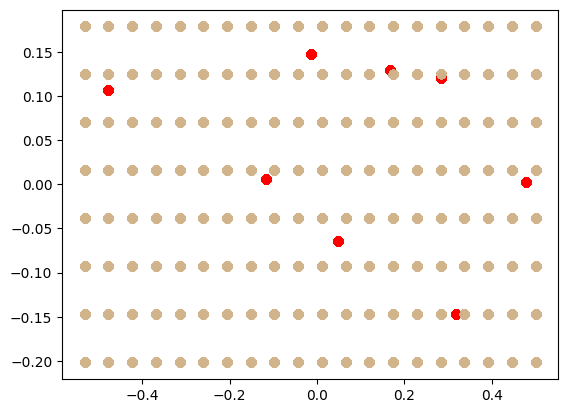

In [41]:
plt.scatter(X_WS, Y_WS, alpha=0.2, c="red")
plt.scatter(X_PINN, Y_PINN, alpha=0.2, c="tan")
plt.show()

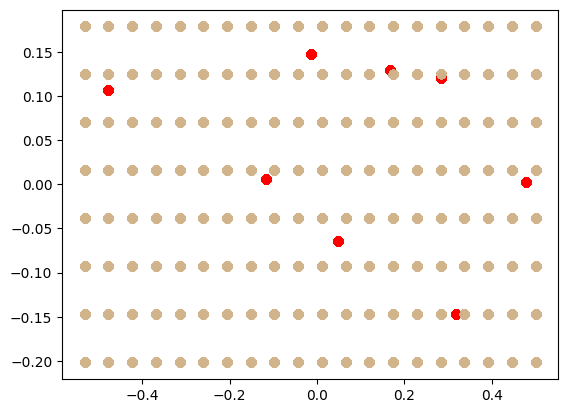

In [42]:
plt.scatter(X_WS, Y_WS, alpha=0.2, c="red")
plt.scatter(X_PINN, Y_PINN, alpha=0.2, c="tan")
plt.show()

In [ ]:
# Final output grid
X_PINN, Y_PINN = np.meshgrid(x_PINN, y_PINN)
print(X_PINN.shape, Y_PINN.shape)
print(X_PINN.flatten('F').shape)
print(X_PINN.flatten('F')[:, None].shape)
print(X_PINN.flatten('F').reshape(-1,1).shape)
# X_PINN = X_PINN.flatten('F')[:, None]
# Y_PINN = Y_PINN.flatten('F')[:, None]
# print(X_PINN.shape, Y_PINN.shape)

(8, 20) (8, 20)
(160,)
(160, 1)
(160, 1)


In [ ]:
# Final output grid
X_PINN, Y_PINN = np.meshgrid(x_PINN, y_PINN)
print(X_PINN.shape, Y_PINN.shape)
X_PINN = X_PINN.flatten('F')[:, None]
Y_PINN = Y_PINN.flatten('F')[:, None]
print(X_PINN.shape, Y_PINN.shape)

(8, 20) (8, 20)
(160, 1) (160, 1)


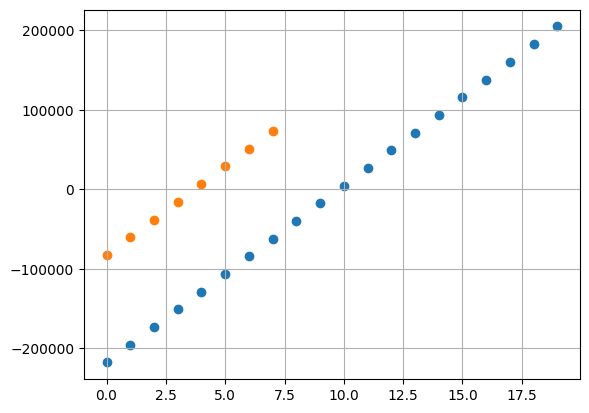

In [43]:
import matplotlib.pyplot as plt

plt.scatter(range(x_PINN.shape[0]),x_PINN)
plt.scatter(range(y_PINN.shape[0]),y_PINN)
plt.grid()
plt.show()

In [ ]:
X, Y = np.meshgrid(x_PINN, y_PINN)
print(X.shape, Y.shape)
for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    print(f"X({i},{j})={X[i,j]}")

(8, 20) (8, 20)
X(0,0)=-218061.9194898727
X(0,1)=-195798.54476357572
X(0,2)=-173535.17003727873
X(0,3)=-151271.79531098175
X(0,4)=-129008.42058468476
X(0,5)=-106745.04585838778
X(0,6)=-84481.67113209079
X(0,7)=-62218.29640579381
X(0,8)=-39954.92167949682
X(0,9)=-17691.54695319984
X(0,10)=4571.827773097146
X(0,11)=26835.20249939413
X(0,12)=49098.577225691115
X(0,13)=71361.9519519881
X(0,14)=93625.32667828508
X(0,15)=115888.70140458207
X(0,16)=138152.07613087905
X(0,17)=160415.45085717604
X(0,18)=182678.82558347302
X(0,19)=204942.20030977
X(1,0)=-218061.9194898727
X(1,1)=-195798.54476357572
X(1,2)=-173535.17003727873
X(1,3)=-151271.79531098175
X(1,4)=-129008.42058468476
X(1,5)=-106745.04585838778
X(1,6)=-84481.67113209079
X(1,7)=-62218.29640579381
X(1,8)=-39954.92167949682
X(1,9)=-17691.54695319984
X(1,10)=4571.827773097146
X(1,11)=26835.20249939413
X(1,12)=49098.577225691115
X(1,13)=71361.9519519881
X(1,14)=93625.32667828508
X(1,15)=115888.70140458207
X(1,16)=138152.07613087905
X(1,17)=

In [ ]:
print(X.shape, Y.shape)
for j in range(X.shape[1]):
  for i in range(X.shape[0]):
    print(f"X({i},{j})={X[i,j]}")

(8, 20) (8, 20)
X(0,0)=-218061.9194898727
X(1,0)=-218061.9194898727
X(2,0)=-218061.9194898727
X(3,0)=-218061.9194898727
X(4,0)=-218061.9194898727
X(5,0)=-218061.9194898727
X(6,0)=-218061.9194898727
X(7,0)=-218061.9194898727
X(0,1)=-195798.54476357572
X(1,1)=-195798.54476357572
X(2,1)=-195798.54476357572
X(3,1)=-195798.54476357572
X(4,1)=-195798.54476357572
X(5,1)=-195798.54476357572
X(6,1)=-195798.54476357572
X(7,1)=-195798.54476357572
X(0,2)=-173535.17003727873
X(1,2)=-173535.17003727873
X(2,2)=-173535.17003727873
X(3,2)=-173535.17003727873
X(4,2)=-173535.17003727873
X(5,2)=-173535.17003727873
X(6,2)=-173535.17003727873
X(7,2)=-173535.17003727873
X(0,3)=-151271.79531098175
X(1,3)=-151271.79531098175
X(2,3)=-151271.79531098175
X(3,3)=-151271.79531098175
X(4,3)=-151271.79531098175
X(5,3)=-151271.79531098175
X(6,3)=-151271.79531098175
X(7,3)=-151271.79531098175
X(0,4)=-129008.42058468476
X(1,4)=-129008.42058468476
X(2,4)=-129008.42058468476
X(3,4)=-129008.42058468476
X(4,4)=-129008.42058

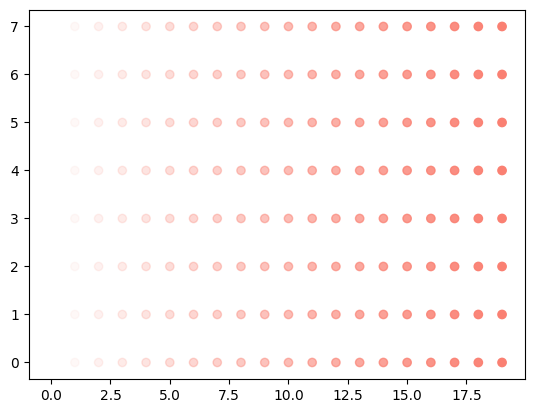

In [ ]:
for i in range(X.shape[0]):
  xmin = X[i].min()
  xmax = X[i].max()
  alpha = (X[i] - xmin)/(xmax - xmin)
  plt.scatter(range(X[i].shape[0]), np.zeros(X[i].shape[0]) + i, alpha=alpha, c="salmon")
plt.show()

In [ ]:
print(X.shape, Y.shape)
for i in range(Y.shape[0]):
  for j in range(Y.shape[1]):
    print(f"Y({i},{j})={Y[i,j]}")
plt.show()

(8, 20) (8, 20)
Y(0,0)=-82639.04852147866
Y(0,1)=-82639.04852147866
Y(0,2)=-82639.04852147866
Y(0,3)=-82639.04852147866
Y(0,4)=-82639.04852147866
Y(0,5)=-82639.04852147866
Y(0,6)=-82639.04852147866
Y(0,7)=-82639.04852147866
Y(0,8)=-82639.04852147866
Y(0,9)=-82639.04852147866
Y(0,10)=-82639.04852147866
Y(0,11)=-82639.04852147866
Y(0,12)=-82639.04852147866
Y(0,13)=-82639.04852147866
Y(0,14)=-82639.04852147866
Y(0,15)=-82639.04852147866
Y(0,16)=-82639.04852147866
Y(0,17)=-82639.04852147866
Y(0,18)=-82639.04852147866
Y(0,19)=-82639.04852147866
Y(1,0)=-60375.67379518133
Y(1,1)=-60375.67379518133
Y(1,2)=-60375.67379518133
Y(1,3)=-60375.67379518133
Y(1,4)=-60375.67379518133
Y(1,5)=-60375.67379518133
Y(1,6)=-60375.67379518133
Y(1,7)=-60375.67379518133
Y(1,8)=-60375.67379518133
Y(1,9)=-60375.67379518133
Y(1,10)=-60375.67379518133
Y(1,11)=-60375.67379518133
Y(1,12)=-60375.67379518133
Y(1,13)=-60375.67379518133
Y(1,14)=-60375.67379518133
Y(1,15)=-60375.67379518133
Y(1,16)=-60375.67379518133
Y(1,1

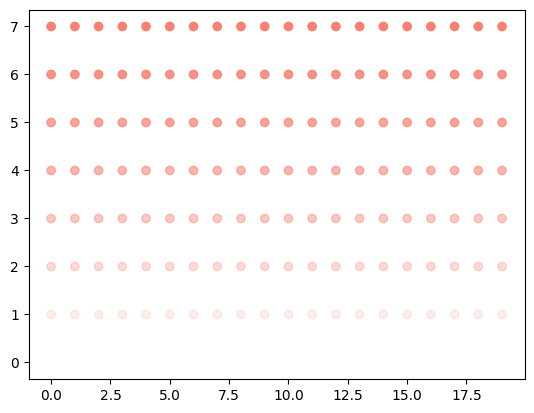

In [ ]:
for j in range(Y.shape[1]):
  ymin = Y[:,j].min()
  ymax = Y[:,j].max()
  alpha = (Y[:,j] - ymin)/(ymax - ymin)
  plt.scatter(np.zeros(Y.shape[0]) + j, range(Y[:,j].shape[0]), alpha=alpha, c="salmon")
  # plt.scatter(range(X[i].shape[0]), np.zeros(X[i].shape[0]) + i, alpha=alpha[j], c="salmon")
# plt.show()

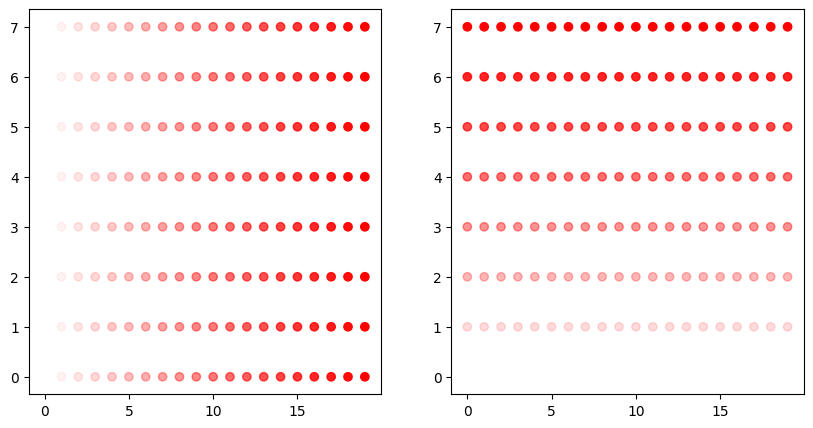

In [ ]:
fig , ax = plt.subplots(1,2, figsize=(10,5))
for i in range(X.shape[0]):
  xmin = X[i].min()
  xmax = X[i].max()
  alpha_x = (X[i] - xmin)/(xmax - xmin)
  ax[0].scatter(range(X[i].shape[0]), np.zeros(X[i].shape[0]) + i, alpha=alpha_x, c="red")

for j in range(Y.shape[1]):
  ymin = Y[:,j].min()
  ymax = Y[:,j].max()
  alpha_y = (Y[:,j] - ymin)/(ymax - ymin)
  ax[1].scatter(np.zeros(Y.shape[0]) + j, range(Y[:,j].shape[0]), alpha=alpha_y, c="red")

plt.show()

In [ ]:
WS = [T_WS,X_WS,Y_WS,Z_WS,U_WS,V_WS,P_WS,Temp_WS,]

In [ ]:
for ws in WS:
    print(ws.shape)

(21, 2016)
(21, 2016)
(21, 2016)
(21, 2016)
(21, 2016)
(21, 2016)
(21, 2016)
(21, 2016)


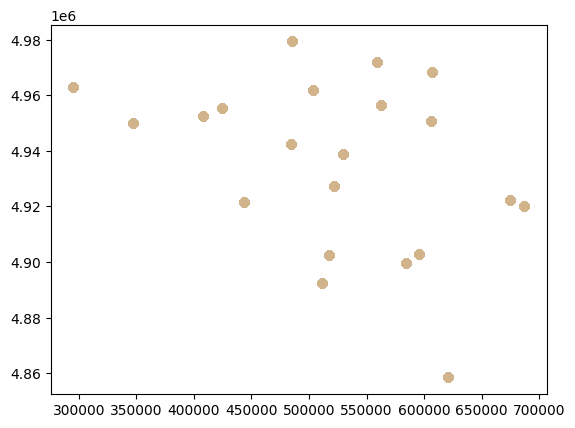

In [ ]:
plt.scatter(X_WS, Y_WS, alpha=0.2, c="tan")
plt.show()

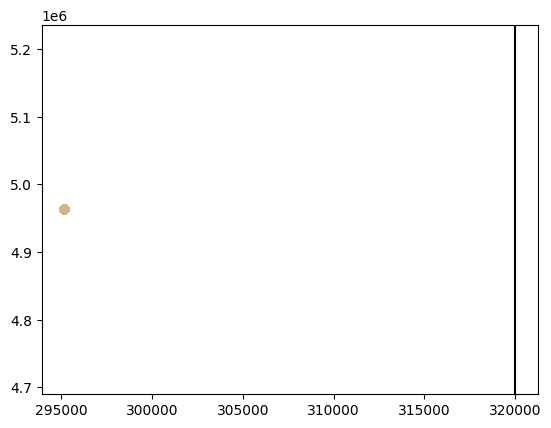

In [ ]:
plt.scatter(X_WS[0], Y_WS[0], alpha=0.5, c="tan")
plt.axvline(x=320_000, color='k')
plt.show()

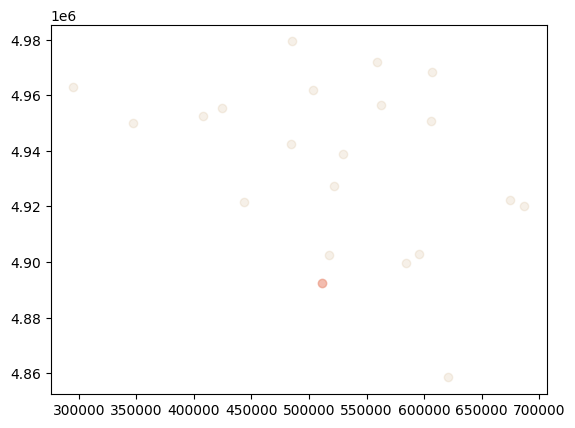

In [ ]:
plt.scatter(X_WS[8,0], Y_WS[8,0], alpha=0.5, c="salmon")
plt.scatter(X_WS[:,0], Y_WS[:,0], alpha=0.2, c="tan")
plt.show()

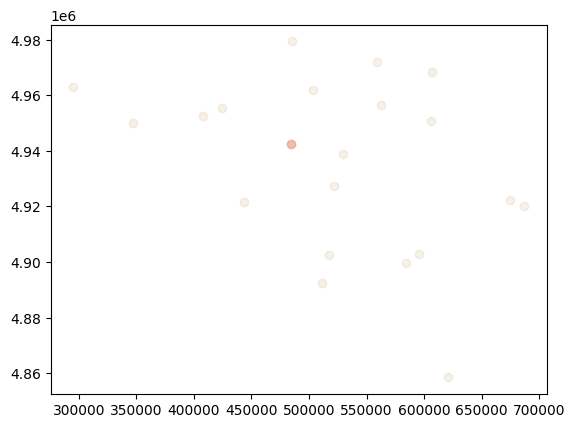

In [ ]:
plt.scatter(X_WS[5,1], Y_WS[5,1], alpha=0.5, c="salmon")
plt.scatter(X_WS[:,1], Y_WS[:,1], alpha=0.2, c="tan")
plt.show()

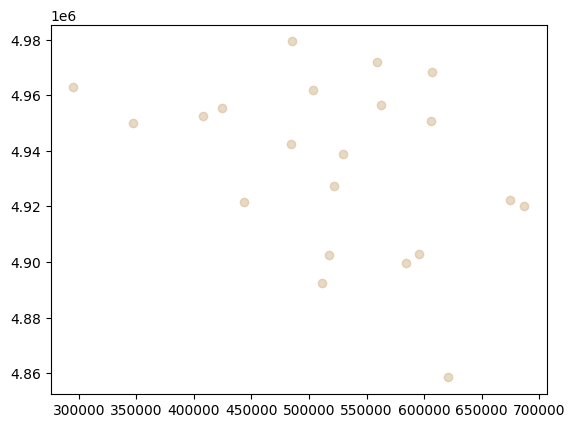

In [ ]:
plt.scatter(X_WS[:,0], Y_WS[:,0], alpha=0.5, c="tan")
plt.show()

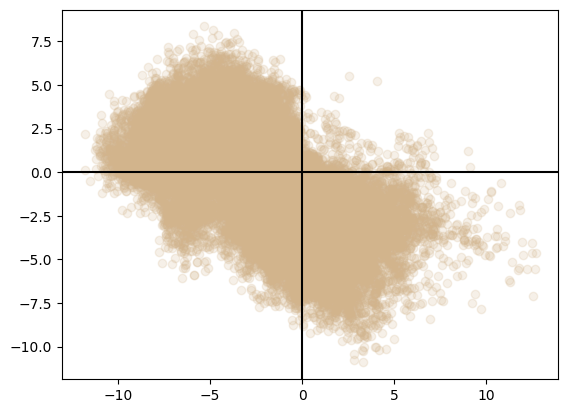

In [ ]:
plt.scatter(U_WS, V_WS, alpha=0.2, c="tan")
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

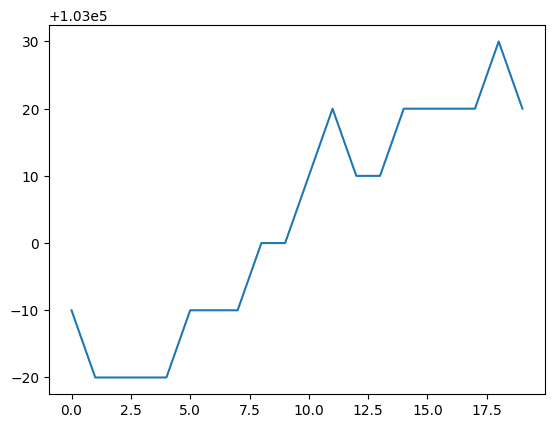

In [ ]:
plt.plot(P_WS[0][80:100])
plt.show()

In [ ]:
tiempo = list()
idx_0 = list()
for idx in range(X_WS.shape[1]):
  idx_val = np.argwhere(X_WS[:,idx] < 320_000)[0,0]
  idx_0.append(idx_val)
  tiempo.append(T_WS[idx_val,idx])


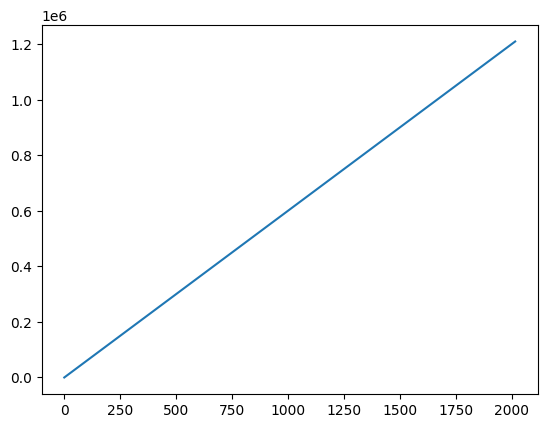

In [ ]:
# plt.plot(tiempo)
plt.plot(T_WS[idx_val,:])
plt.show()

In [ ]:
Temp_WS[idx_val,:] , Temp_WS[idx_val,:].shape

(array([ 2.1,  2.4,  2.3, ..., 13.5, 13.4, 13.9]), (2016,))

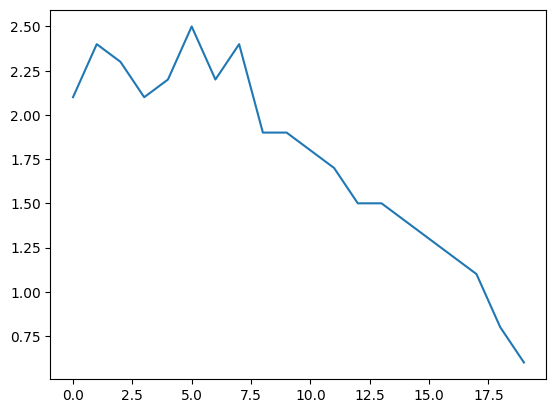

In [ ]:
plt.plot(Temp_WS[0][:20])
plt.show()